In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2024-05-05 12:25:55.241470: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


resources

https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

In [2]:
path_to_zip = "./"
PATH = os.path.join(os.path.dirname(path_to_zip), 'images')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

BATCH_SIZE = 32
IMG_SIZE = (40, 40)
IMG_SHAPE = IMG_SIZE + (3,)



In [3]:
img_height, img_width = 40, 40
train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="both",
  shuffle=True,
  seed=13,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE)
#val_ds = tf.keras.utils.image_dataset_from_directory(
#  validation_dir,
#  shuffle=True,
#  image_size=(img_height, img_width),
#  batch_size=BATCH_SIZE)




Found 149883 files belonging to 65 classes.
Using 119907 files for training.
Using 29976 files for validation.


2024-05-05 12:26:09.064780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


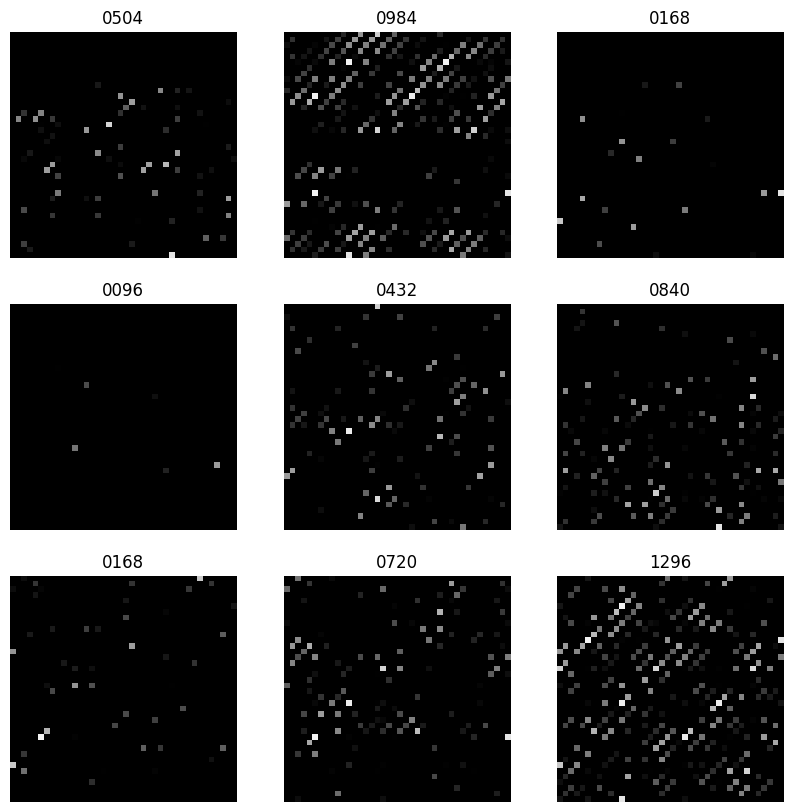

In [4]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [5]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)


In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 750
Number of test batches: 187


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)



# Basic image --classification-- regression

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

In [35]:
model = Sequential([
    layers.InputLayer(shape=IMG_SHAPE),
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.AveragePooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.AveragePooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, 5, padding='same', activation='relu'),
    layers.AveragePooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1),
])

model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 40, 40, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 40, 40, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 20, 20, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 20, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 20, 20, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_7             │ (None, 10, 10, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10, 10, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 10, 10, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_8             │ (None, 5, 5, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       409,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 512,993 (1.96 MB)

 Trainable params: 512,737 (1.96 MB)

 Non-trainable params: 256 (1.00 KB)

In [36]:
model.evaluate(validation_dataset)


937/937 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 930.6389 - mae: 26.2413


[917.24169921875, 26.03429412841797]

In [37]:
epochs=50
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)


Epoch 1/50
3748/3748 ━━━━━━━━━━━━━━━━━━━━ 196s 52ms/step - loss: 103.0658 - mae: 7.6003 - val_loss: 41.6374 - val_mae: 4.7500
Epoch 2/50
3748/3748 ━━━━━━━━━━━━━━━━━━━━ 185s 49ms/step - loss: 62.7711 - mae: 5.8409 - val_loss: 36.5009 - val_mae: 4.2799
Epoch 3/50
3748/3748 ━━━━━━━━━━━━━━━━━━━━ 184s 49ms/step - loss: 51.1315 - mae: 5.2028 - val_loss: 45.3724 - val_mae: 5.0508
Epoch 4/50
3748/3748 ━━━━━━━━━━━━━━━━━━━━ 184s 49ms/step - loss: 45.1887 - mae: 4.8244 - val_loss: 44.1741 - val_mae: 4.9876
Epoch 5/50
3748/3748 ━━━━━━━━━━━━━━━━━━━━ 184s 49ms/step - loss: 41.0181 - mae: 4.5613 - val_loss: 35.1828 - val_mae: 4.1600
Epoch 6/50
3748/3748 ━━━━━━━━━━━━━━━━━━━━ 185s 49ms/step - loss: 37.0187 - mae: 4.3103 - val_loss: 31.5239 - val_mae: 3.9534
Epoch 7/50
3748/3748 ━━━━━━━━━━━━━━━━━━━━ 185s 49ms/step - loss: 33.9260 - mae: 4.1110 - val_loss: 26.0679 - val_mae: 3.4144
Epoch 8/50
3748/3748 ━━━━━━━━━━━━━━━━━━━━ 185s 49ms/step - loss: 31.3349 - mae: 3.9530 - val_loss: 25.7579 - val_mae: 3.4593

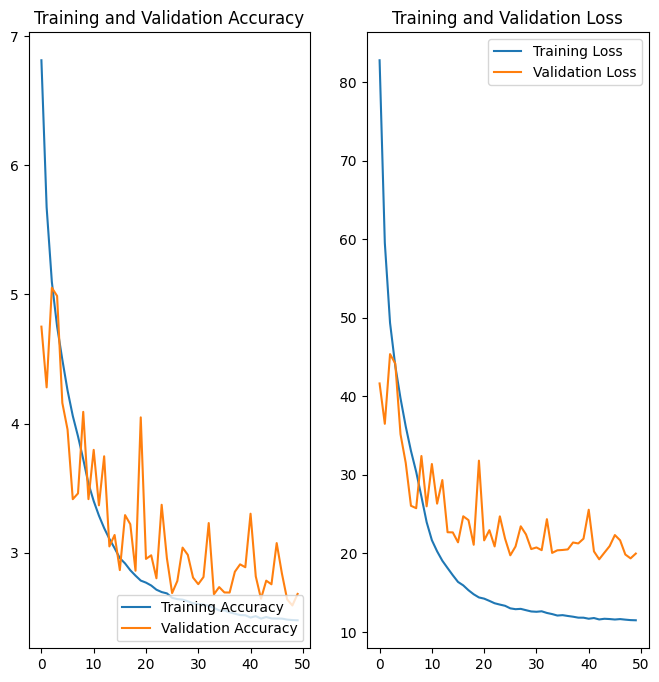

In [38]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [39]:
model.save("regression-adam.keras")

In [40]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=False,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
)

Found 20548 files belonging to 65 classes.


In [41]:
model.evaluate(test_ds)

643/643 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 121.6517 - mae: 6.6683


[67.80274200439453, 6.141038417816162]

In [42]:
predictions = model.predict(test_ds)

643/643 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step


In [43]:
y_true = np.array([], dtype=int)
for image_batch, label_batch in test_ds:
   y_true = np.append(y_true, label_batch)
y_pred = np.hstack(predictions)
y_true, y_pred = np.array(y_true), np.array(y_pred)

2024-05-06 00:27:43.959091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [44]:
entropy_true = y_true*24+48
entropy_true

array([  48,   48,   48,   48,   48,   48,   48,   48,   48,   48,   48,
         48,   48,   48,   48,   48,   48,   48,   48,   48,   48,   48,
         48,   48,   48,   48,   48,   48,   48,   48,   48,   48,   48,
         48,   48,   48,   48,   48,   48,   48,   48,   48,   48,   48,
         48,   48,   48,   48,   48,   48,   48,   48,   48,   48,   48,
         48,   48,   48,   48,   48,   48,   48,   48,   48,   48,   48,
         48,   48,   72,   72,   72,   72,   72,   72,   72,   72,   72,
         72,   72,   72,   72,   72,   72,   72,   72,   72,   72,   72,
         72,   72,   72,   72,   72,   72,   72,   72,   72,   72,   72,
         72,   72,   72,   72,   72,   72,   72,   72,   72,   72,   72,
         72,   72,   72,   72,   72,   72,   72,   72,   72,   72,   72,
         72,   72,   72,   72,   72,   72,   72,   72,   72,   72,   72,
         72,   72,   72,   72,   72,   72,   72,   72,   72,   72,   72,
         72,   72,   72,   72,   72,   72,   72,   

In [45]:
entropy_pred = y_pred*24+48
entropy_pred[entropy_pred>max(entropy_true)]=max(entropy_true)
entropy_pred

array([1516.4674  , 1584.      , 1278.9583  , 1335.6295  , 1584.      ,
       1462.0233  , 1278.9583  , 1532.2358  , 1245.5681  , 1519.7828  ,
       1424.9478  , 1297.7356  , 1526.9568  , 1464.3225  , 1437.2327  ,
       1423.6658  , 1432.8407  , 1581.6224  , 1289.2299  , 1492.7495  ,
       1493.7827  , 1584.      , 1355.064   , 1289.2299  , 1584.      ,
       1464.3225  , 1531.1929  , 1390.7943  , 1536.9628  , 1517.9746  ,
       1402.2988  , 1476.6089  , 1367.804   , 1568.4592  , 1485.2327  ,
       1402.2987  ,  966.056   , 1464.3225  , 1584.      , 1549.9639  ,
       1493.7827  , 1335.6295  , 1562.7926  , 1323.6755  , 1531.0768  ,
       1584.      , 1547.2675  , 1446.0012  , 1418.7148  , 1532.2358  ,
       1298.3038  , 1335.6295  , 1352.0692  , 1423.6658  , 1565.6875  ,
       1532.2358  , 1361.4213  , 1447.4185  , 1343.8599  , 1446.6616  ,
       1278.9583  , 1580.6663  , 1361.4214  , 1559.8164  , 1531.1929  ,
       1476.0986  , 1526.9568  , 1191.1138  ,  359.86658 ,  541.

In [46]:
np.mean(np.abs(entropy_pred-entropy_true)/entropy_true) # mape

0.3569295920855319

In [47]:
np.mean(entropy_pred)

720.2142

In [48]:
## group back into classes
import sys
np.set_printoptions(threshold=sys.maxsize)
bins = np.linspace(0, 1584, 10)
labels_pred = np.digitize(entropy_pred, bins)
labels_true = np.digitize(entropy_true, bins)

acc = np.mean(labels_pred==labels_true)
acc

0.35375705664784896

In [49]:
labels_pred

array([ 9, 10,  8,  8, 10,  9,  8,  9,  8,  9,  9,  8,  9,  9,  9,  9,  9,
        9,  8,  9,  9, 10,  8,  8, 10,  9,  9,  8,  9,  9,  8,  9,  8,  9,
        9,  8,  6,  9, 10,  9,  9,  8,  9,  8,  9, 10,  9,  9,  9,  9,  8,
        8,  8,  9,  9,  9,  8,  9,  8,  9,  8,  9,  8,  9,  9,  9,  9,  7,
        3,  4,  2,  2,  1,  2,  2,  2,  3,  1,  1,  2,  2,  3,  2,  2,  1,
        2,  1,  2,  3,  2,  2,  3,  2,  3,  2,  2,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  2,
        1,  1,  1,  1,  2,  1,  3,  2,  2,  3,  2,  1,  2,  1,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  1,  2,  1,  2,  2,  2,  1,  2,  3,  2,
        3,  2,  2,  1,  2,  1,  2,  1,  2,  1,  2,  2,  2,  1,  1,  2,  1,
        2,  1,  1,  2,  1,  1,  2,  1,  2,  2,  1,  1,  1,  2,  1,  1,  2,
        1,  2,  2,  2,  1,  1,  1,  2,  2,  1,  3,  2,  2,  2,  2,  2,  1,
        2,  2,  1,  3,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2

<Axes: >

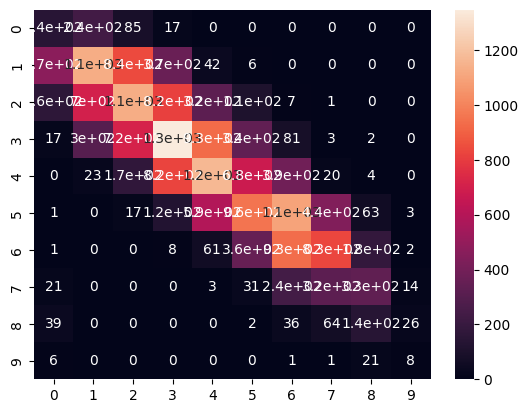

In [50]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(labels_pred, labels_true), annot=True)

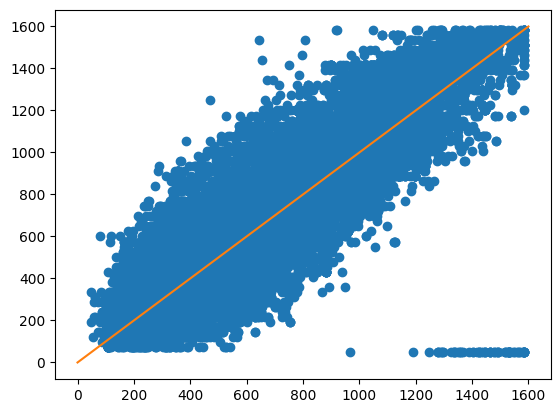

In [51]:
x_axis = np.linspace(0, 1600, 10000) # start, stop, num
y_axis = np.linspace(0, 1600, 10000)
plt.plot(entropy_pred, entropy_true, 'o')
plt.plot(x_axis, y_axis)
plt.show()

In [32]:
class EmpiricEntropy(tf.keras.layers.Layer):
  def __init__(self):
      super(EmpiricEntropy, self).__init__()
      
  def call(self, inputs):
      
      x = tf.math.reduce_sum(inputs)
      return x


In [33]:
empiric_model = Sequential([
    layers.InputLayer(IMG_SHAPE),
    layers.Rescaling(1./255),
    layers.Flatten(),
    EmpiricEntropy(),
])

empiric_model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])
empiric_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 40, 40, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ empiric_entropy                 │ ()                     │             0 │
│ (EmpiricEntropy)                │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
empiric_model.evaluate(validation_dataset)

937/937 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9394823.0000 - mae: 3038.3086


[9221728.0, 3010.28173828125]

In [16]:
class_names = test_ds.class_names

for images, labels in test_ds.take(1):
  print(len(images))
  print(model.predict(images))


32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[-0.3721823 ]
 [-0.42818648]
 [-0.23759425]
 [-0.24569704]
 [-0.19450878]
 [-0.09513127]
 [-0.23759425]
 [-0.1194225 ]
 [-0.15710372]
 [-0.19340923]
 [-0.06611493]
 [-0.09913912]
 [-0.15177703]
 [-0.23232713]
 [-0.34151438]
 [-0.355371  ]
 [-0.04678857]
 [-0.06287003]
 [-0.19014278]
 [-0.27654958]
 [-0.17061806]
 [-0.42818648]
 [-0.29961362]
 [-0.19014278]
 [-0.35974878]
 [-0.23232713]
 [-0.24737063]
 [-0.22948635]
 [-0.12905349]
 [-0.31242758]
 [-0.08790575]
 [-0.06119327]]


2024-05-04 15:07:09.302497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
